In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler

In [5]:
mpl.style.use("seaborn-v0_8-deep")
mpl.rcParams["figure.figsize"] = (20, 5)
mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

In [6]:
# Load the dataset
data = pd.read_pickle(
    "D:\\Projects\\Solar Forcasting\\Processed Data\\Pickle files\\feature_engineered_data.pkl"
)
data.reset_index(inplace=True)

# List of important features
important_features = [
    "Sqrt_Sum_of_Squares",
    "pca_2",
    "DNI_freq_1.429_Hz_ws_14",
    "cluster",
    "Wind Direction",
    "DNI_pse",
    "DNI_freq_1.071_Hz_ws_14",
    "DNI_freq_weighted",
    "DNI_freq_0.357_Hz_ws_14",
    "DNI_freq_0.0_Hz_ws_14",
]

# Target variable
target = ["DNI"]

# Scaling the features and target variable
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

data_scaled = data.copy()
data_scaled[important_features] = scaler_features.fit_transform(
    data[important_features]
)
data_scaled[target] = scaler_target.fit_transform(data[target])

# Splitting the data based on year
train = data_scaled[data_scaled["datetime"].dt.year.between(2016, 2019)]
test = data_scaled[data_scaled["datetime"].dt.year == 2020]

# Extracting features and target from train and test sets
X_train, y_train = train[important_features].values, train[target].values
X_test, y_test = test[important_features].values, test[target].values


# Function to create sequences for RNN
def create_sequences(data, label, sequence_length):
    sequence_data, sequence_label = [], []
    for i in range(len(data) - sequence_length):
        sequence_data.append(data[i : i + sequence_length])
        sequence_label.append(label[i + sequence_length])
    return np.array(sequence_data), np.array(sequence_label)


# Creating sequences with a sequence length of 10
sequence_length = 10
X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` in

ANN


In [8]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout


def objective(trial):
    # Define hyperparameters to be tuned
    num_layers = trial.suggest_int("num_layers", 1, 3)
    units = trial.suggest_categorical("units", [32, 64, 128, 256])
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5, step=0.1)
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-2, log=True)

    model = Sequential()
    model.add(Dense(units, activation="relu", input_shape=(10,)))

    for i in range(num_layers):
        model.add(Dense(units, activation="relu"))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation="linear"))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

    # Train the model
    history = model.fit(
        X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0
    )

    # Return the validation loss
    return history.history["val_loss"][-1]


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the result
print(f"Number of finished trials: {len(study.trials)}")
print(f"Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2023-11-01 17:28:35,973] A new study created in memory with name: no-name-192dab25-3906-482e-9133-c9936ff656f6


[I 2023-11-01 17:29:37,363] Trial 0 finished with value: 0.0004955250769853592 and parameters: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.2, 'lr': 5.0931891980686874e-05}. Best is trial 0 with value: 0.0004955250769853592.
[I 2023-11-01 17:30:28,725] Trial 1 finished with value: 0.0003042462922167033 and parameters: {'num_layers': 1, 'units': 32, 'dropout_rate': 0.2, 'lr': 0.001337252623202752}. Best is trial 1 with value: 0.0003042462922167033.
[I 2023-11-01 17:31:28,392] Trial 2 finished with value: 0.0006365866283886135 and parameters: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.5, 'lr': 0.00443503280516448}. Best is trial 1 with value: 0.0003042462922167033.
[I 2023-11-01 17:32:22,993] Trial 3 finished with value: 0.0011031870963051915 and parameters: {'num_layers': 2, 'units': 32, 'dropout_rate': 0.2, 'lr': 0.0005834041688032273}. Best is trial 1 with value: 0.0003042462922167033.
[I 2023-11-01 17:33:21,188] Trial 4 finished with value: 7.412796549033374e-05 and paramet

Number of finished trials: 50
Best trial:
  Value: 3.429630305618048e-05
  Params: 
    num_layers: 1
    units: 64
    dropout_rate: 0.0
    lr: 0.0010179762747588306


Epoch 1/100
5258/5258 [==============================] - 14s 2ms/step - loss: 6.4176e-04 - mse: 6.4176e-04 - val_loss: 9.9374e-05 - val_mse: 9.9374e-05
Epoch 2/100
5258/5258 [==============================] - 13s 3ms/step - loss: 7.3347e-05 - mse: 7.3347e-05 - val_loss: 5.4291e-05 - val_mse: 5.4291e-05
Epoch 3/100
5258/5258 [==============================] - 12s 2ms/step - loss: 5.7832e-05 - mse: 5.7832e-05 - val_loss: 6.4277e-05 - val_mse: 6.4277e-05
Epoch 4/100
5258/5258 [==============================] - 12s 2ms/step - loss: 4.9236e-05 - mse: 4.9236e-05 - val_loss: 3.8745e-05 - val_mse: 3.8745e-05
Epoch 5/100
5258/5258 [==============================] - 14s 3ms/step - loss: 4.3766e-05 - mse: 4.3766e-05 - val_loss: 3.1912e-05 - val_mse: 3.1912e-05
Epoch 6/100
5258/5258 [==============================] - 12s 2ms/step - loss: 4.1749e-05 - mse: 4.1749e-05 - val_loss: 5.8259e-05 - val_mse: 5.8259e-05
Epoch 7/100
5258/5258 [==============================] - 11s 2ms/step - loss: 3.8974e-05

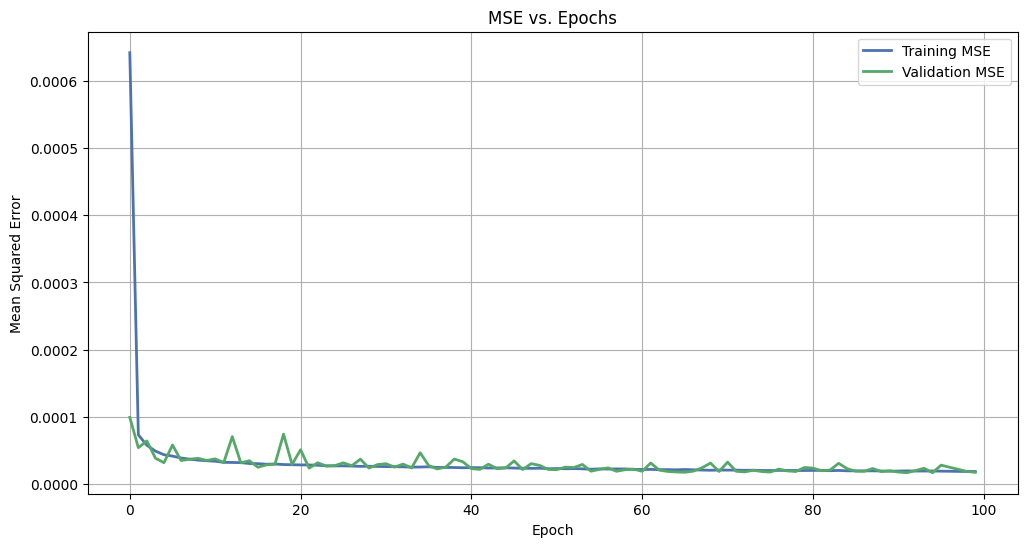

In [10]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load your data and preprocess it as done earlier
# ...

# Best hyperparameters
num_layers = 1
units = 64
dropout_rate = 0.0
learning_rate = 0.0010179762747588306

# Define the ANN model using the best hyperparameters
model = Sequential()
model.add(Dense(units, activation="relu", input_shape=(10,)))

for _ in range(num_layers):
    model.add(Dense(units, activation="relu"))
    model.add(Dropout(dropout_rate))

model.add(Dense(1, activation="linear"))

# Compile the model
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

# Train the model for 100 epochs
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1
)

# Plotting MSE vs. epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history["loss"], label="Training MSE")
plt.plot(history.history["val_loss"], label="Validation MSE")
plt.title("MSE vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.show()

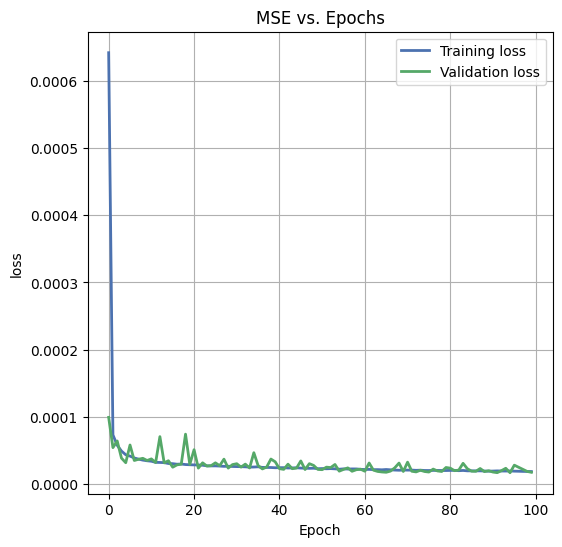

In [13]:
# Plotting MSE vs. epochs
plt.figure(figsize=(6, 6))
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.title("MSE vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.show()

1647/1647 [==============================] - 2s 1ms/step


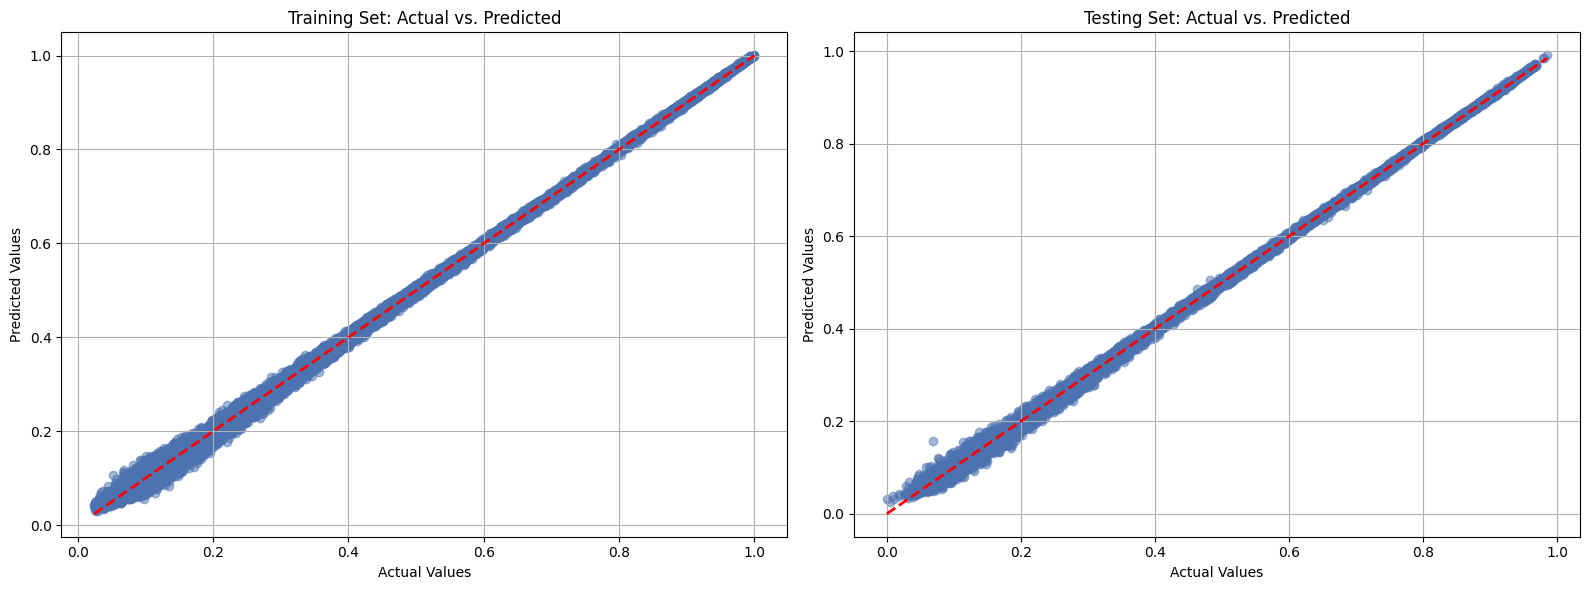

In [14]:
import matplotlib.pyplot as plt

# Make predictions using the trained model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Plotting actual vs. predicted values for the training set
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_train, train_predictions, alpha=0.5)
plt.plot(
    [min(y_train), max(y_train)],
    [min(y_train), max(y_train)],
    color="red",
    linestyle="--",
)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Training Set: Actual vs. Predicted")
plt.grid(True)

# Plotting actual vs. predicted values for the testing set
plt.subplot(1, 2, 2)
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot(
    [min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--"
)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Testing Set: Actual vs. Predicted")
plt.grid(True)

plt.tight_layout()
plt.show()

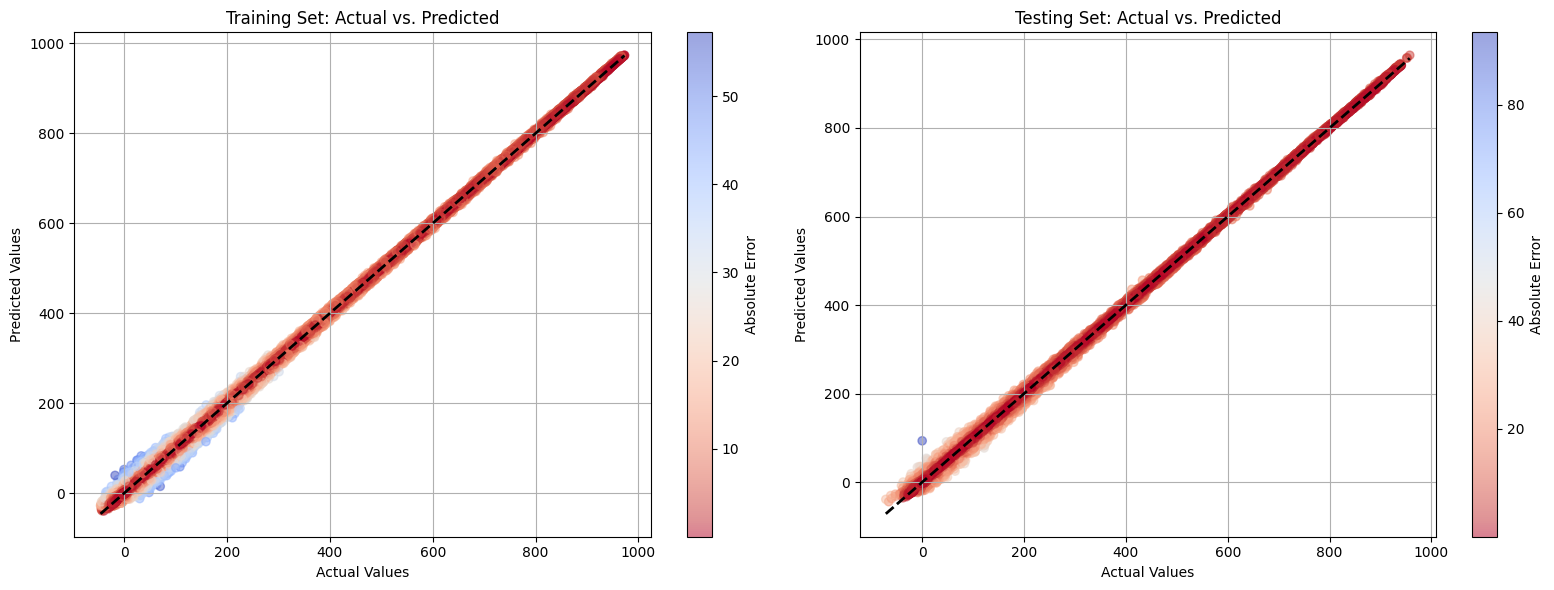

In [28]:
# Inverse transform the scaled data
y_train_original = scaler_target.inverse_transform(y_train)
train_predictions_original = scaler_target.inverse_transform(train_predictions)
y_test_original = scaler_target.inverse_transform(y_test)
test_predictions_original = scaler_target.inverse_transform(test_predictions)

# Calculate absolute errors for color mapping after inverse transformation
train_errors_original = np.abs(
    y_train_original.reshape(-1) - train_predictions_original.reshape(-1)
)
test_errors_original = np.abs(
    y_test_original.reshape(-1) - test_predictions_original.reshape(-1)
)

plt.figure(figsize=(16, 6))

# Plotting actual vs. predicted values for the training set with color based on error
plt.subplot(1, 2, 1)
plt.scatter(
    y_train_original,
    train_predictions_original,
    c=train_errors_original,
    cmap="coolwarm_r",
    alpha=0.5,
)
plt.plot(
    [min(y_train_original), max(y_train_original)],
    [min(y_train_original), max(y_train_original)],
    color="black",
    linestyle="--",
)
plt.colorbar(label="Absolute Error")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Training Set: Actual vs. Predicted")
plt.grid(True)

# Plotting actual vs. predicted values for the testing set with color based on error
plt.subplot(1, 2, 2)
plt.scatter(
    y_test_original,
    test_predictions_original,
    c=test_errors_original,
    cmap="coolwarm_r",
    alpha=0.5,
)
plt.plot(
    [min(y_test_original), max(y_test_original)],
    [min(y_test_original), max(y_test_original)],
    color="black",
    linestyle="--",
)
plt.colorbar(label="Absolute Error")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Testing Set: Actual vs. Predicted")
plt.grid(True)

plt.tight_layout()
plt.show()

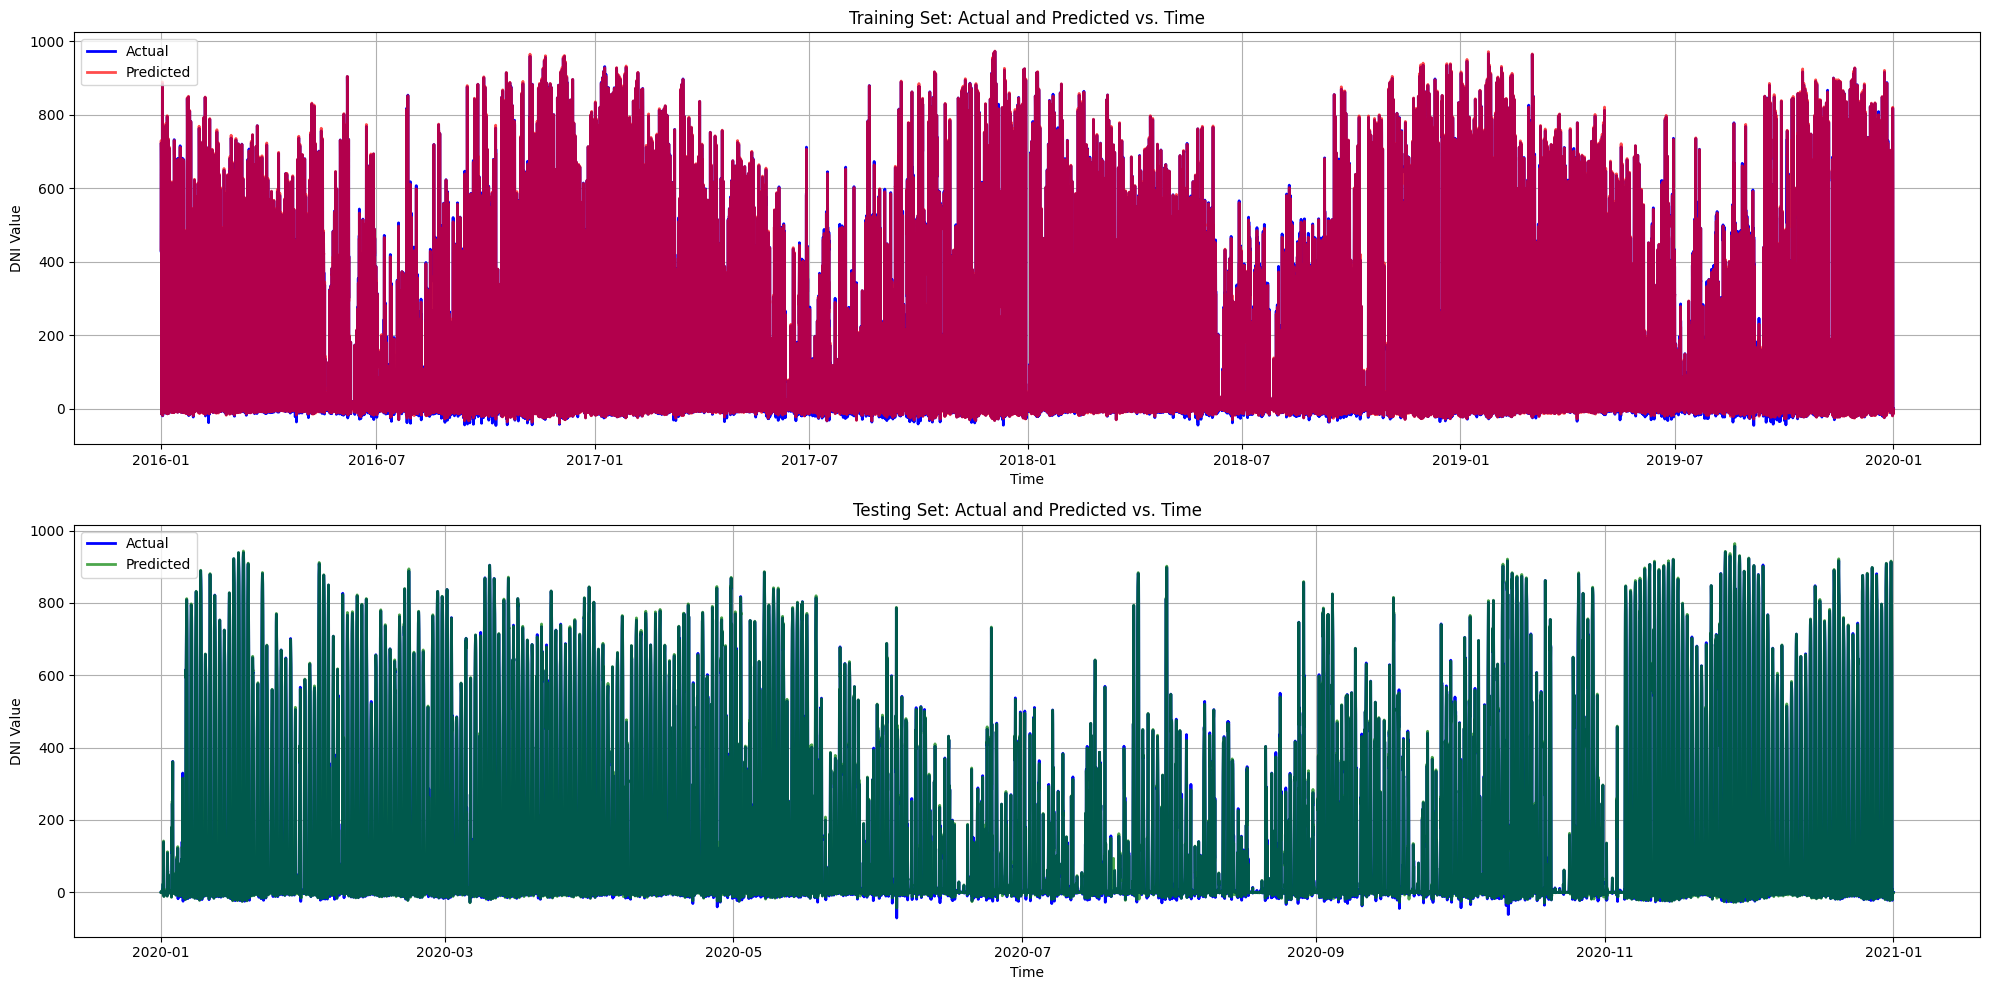

In [27]:
# Inverse transform the scaled data
y_train_original = scaler_target.inverse_transform(y_train)
train_predictions_original = scaler_target.inverse_transform(train_predictions)
y_test_original = scaler_target.inverse_transform(y_test)
test_predictions_original = scaler_target.inverse_transform(test_predictions)

plt.figure(figsize=(20, 10))

# Plotting actual vs. predicted for the training set
plt.subplot(2, 1, 1)
plt.plot(train_time, y_train_original, label="Actual", color="blue")
plt.plot(
    train_time, train_predictions_original, label="Predicted", color="red", alpha=0.7
)
plt.title("Training Set: Actual and Predicted vs. Time")
plt.xlabel("Time")
plt.ylabel("DNI Value")
plt.legend()
plt.grid(True)

# Plotting actual vs. predicted for the testing set
plt.subplot(2, 1, 2)
plt.plot(test_time, y_test_original, label="Actual", color="blue")
plt.plot(
    test_time, test_predictions_original, label="Predicted", color="green", alpha=0.7
)
plt.title("Testing Set: Actual and Predicted vs. Time")
plt.xlabel("Time")
plt.ylabel("DNI Value")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

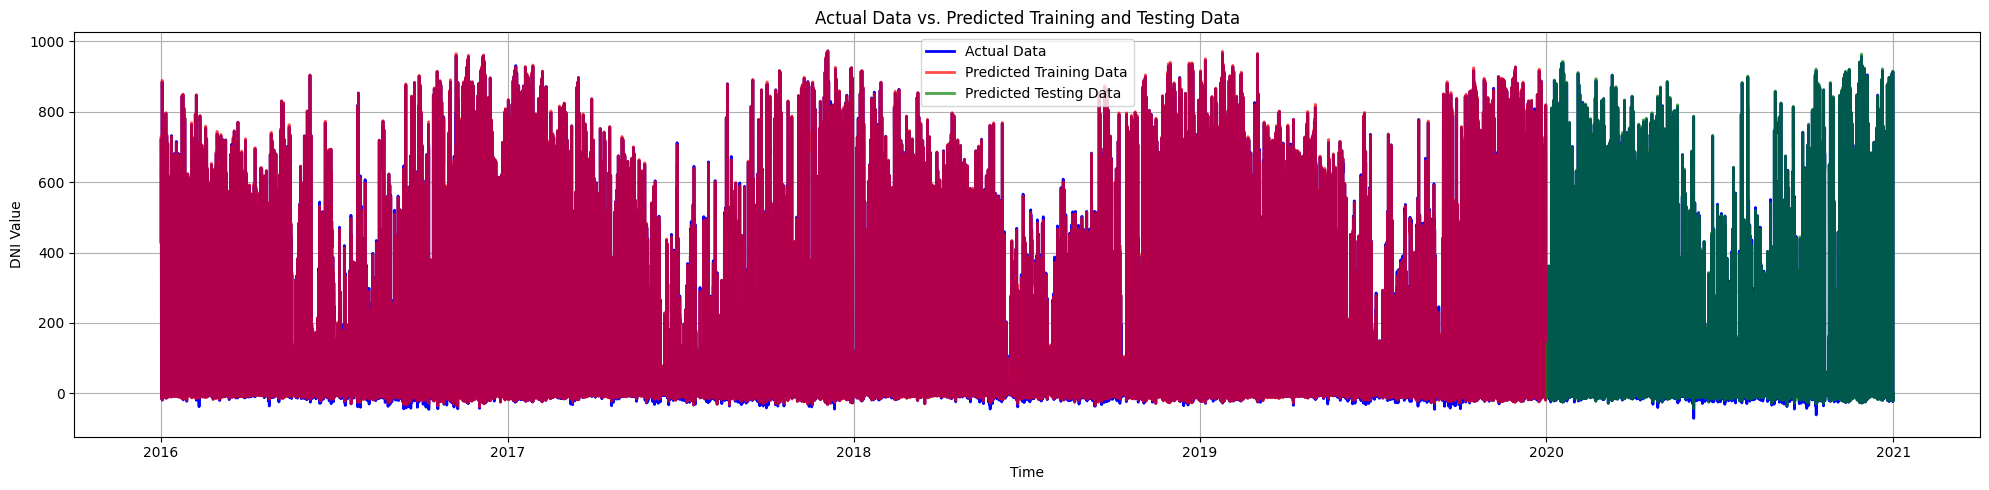

In [26]:
# Inverse transform the scaled data
y_train_original = scaler_target.inverse_transform(y_train)
train_predictions_original = scaler_target.inverse_transform(train_predictions)
y_test_original = scaler_target.inverse_transform(y_test)
test_predictions_original = scaler_target.inverse_transform(test_predictions)

plt.figure(figsize=(20, 5))

# Plotting the entire actual dataset vs. time
plt.plot(full_time, data["DNI"].values, label="Actual Data", color="blue")

# Overlaying predicted values for the training set
plt.plot(
    train_time,
    train_predictions_original,
    label="Predicted Training Data",
    color="red",
    alpha=0.7,
)

# Overlaying predicted values for the testing set
plt.plot(
    test_time,
    test_predictions_original,
    label="Predicted Testing Data",
    color="green",
    alpha=0.7,
)

plt.title("Actual Data vs. Predicted Training and Testing Data")
plt.xlabel("Time")
plt.ylabel("DNI Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Calculate errors for training set
mse_train = mean_squared_error(y_train_original, train_predictions_original)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_original, train_predictions_original)
r2_train = r2_score(y_train_original, train_predictions_original)

# Calculate errors for testing set
mse_test = mean_squared_error(y_test_original, test_predictions_original)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test_original, test_predictions_original)
r2_test = r2_score(y_test_original, test_predictions_original)

# Store errors in the provided DataFrame format
results_df = pd.DataFrame(
    {
        "Dataset": ["Training", "Testing"],
        "MSE": [mse_train, mse_test],
        "RMSE": [rmse_train, rmse_test],
        "MAE": [mae_train, mae_test],
        "R^2": [r2_train, r2_test],
    }
)

print(results_df)

    Dataset        MSE      RMSE       MAE       R^2
0  Training  17.813051  4.220551  2.520232  0.999738
1   Testing  19.136946  4.374580  2.571729  0.999738


In [30]:
reshaped_df = results_df.melt(
    id_vars=["Dataset"],
    value_vars=["MSE", "RMSE", "MAE", "R^2"],
    var_name="Metric",
    value_name="Value",
)

# Pivot the reshaped DataFrame to get the desired format
final_df = reshaped_df.pivot(
    index="Metric", columns="Dataset", values="Value"
).reset_index()

In [31]:
final_df

Dataset,Metric,Testing,Training
0,MAE,2.571729,2.520232
1,MSE,19.136946,17.813051
2,RMSE,4.374580,4.220551
3,R^2,0.999738,0.999738


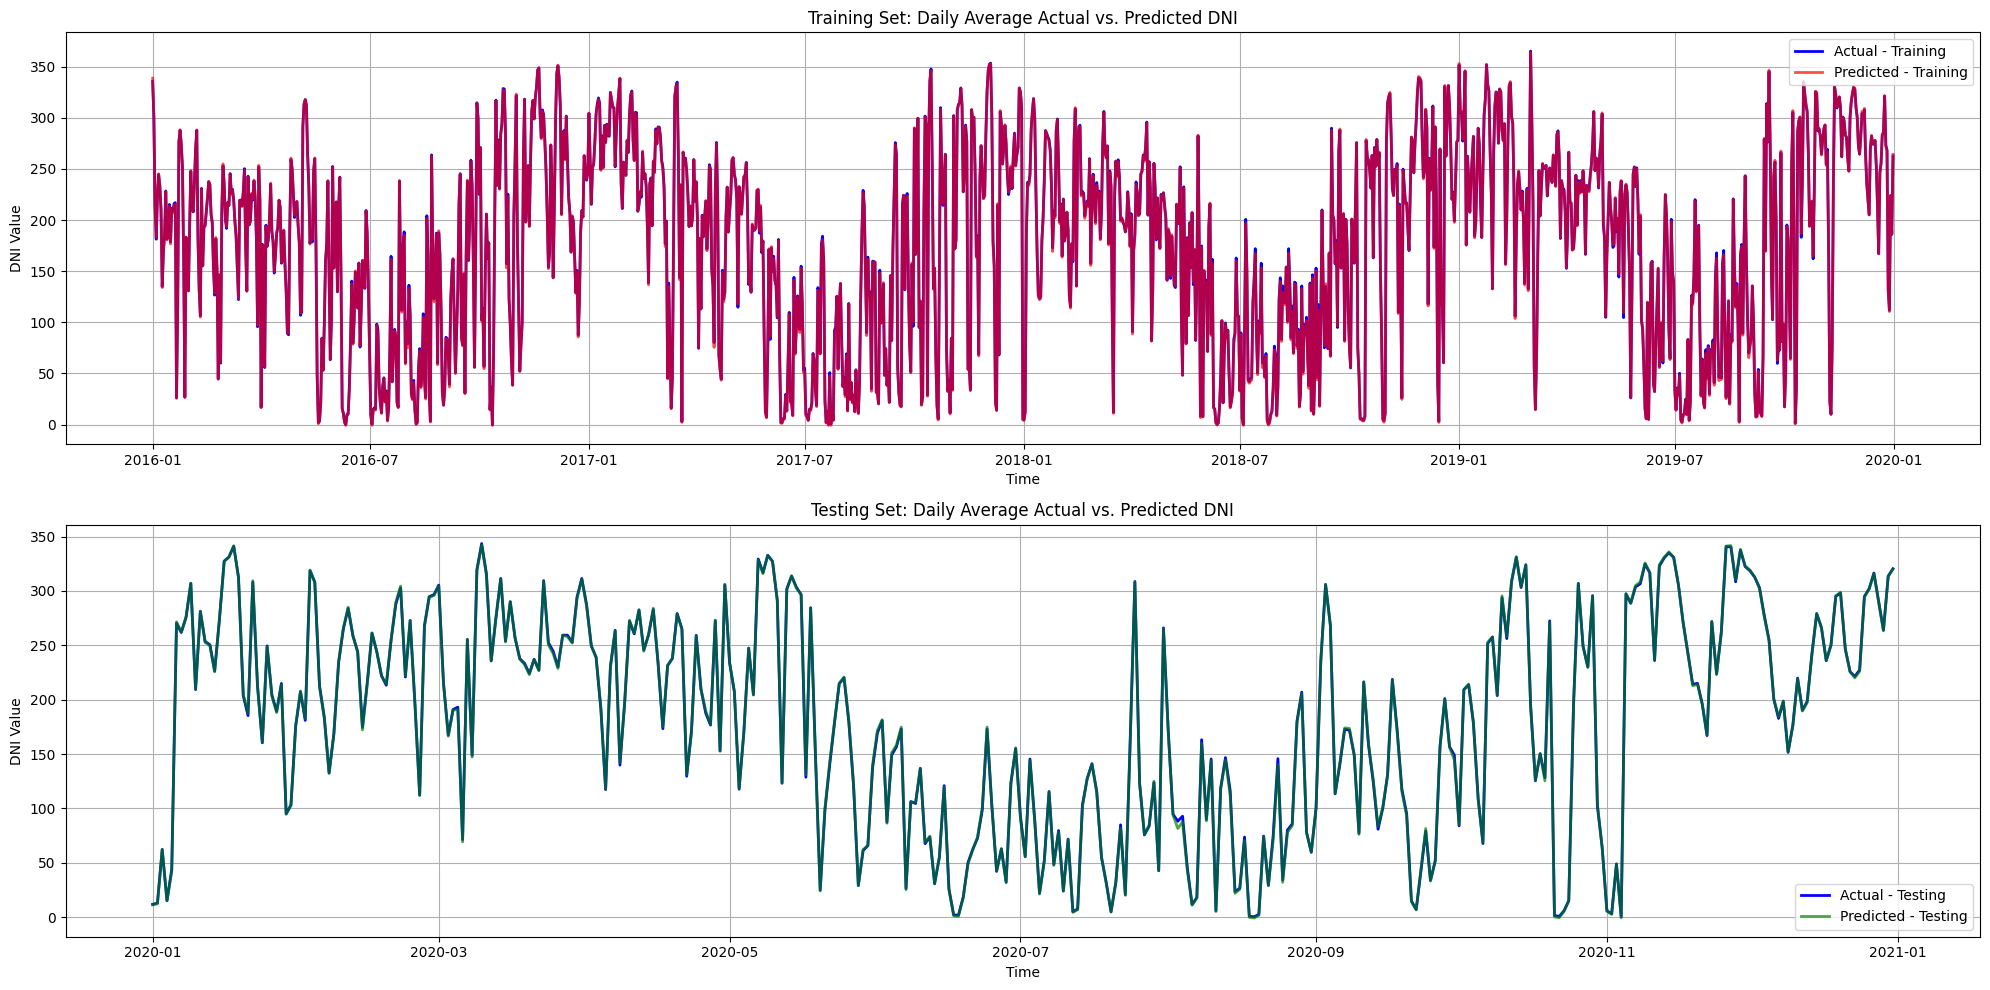

In [36]:
plt.figure(figsize=(20, 10))

# Plotting daily average actual and predicted values for the training set
plt.subplot(2, 1, 1)
plt.plot(
    train_daily.index, train_daily["Actual"], label="Actual - Training", color="blue"
)
plt.plot(
    train_daily.index,
    train_daily["Predicted"],
    label="Predicted - Training",
    color="red",
    alpha=0.7,
)
plt.title("Training Set: Daily Average Actual vs. Predicted DNI")
plt.xlabel("Time")
plt.ylabel("DNI Value")
plt.legend()
plt.grid(True)

# Plotting daily average actual and predicted values for the testing set
plt.subplot(2, 1, 2)
plt.plot(test_daily.index, test_daily["Actual"], label="Actual - Testing", color="blue")
plt.plot(
    test_daily.index,
    test_daily["Predicted"],
    label="Predicted - Testing",
    color="green",
    alpha=0.7,
)
plt.title("Testing Set: Daily Average Actual vs. Predicted DNI")
plt.xlabel("Time")
plt.ylabel("DNI Value")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

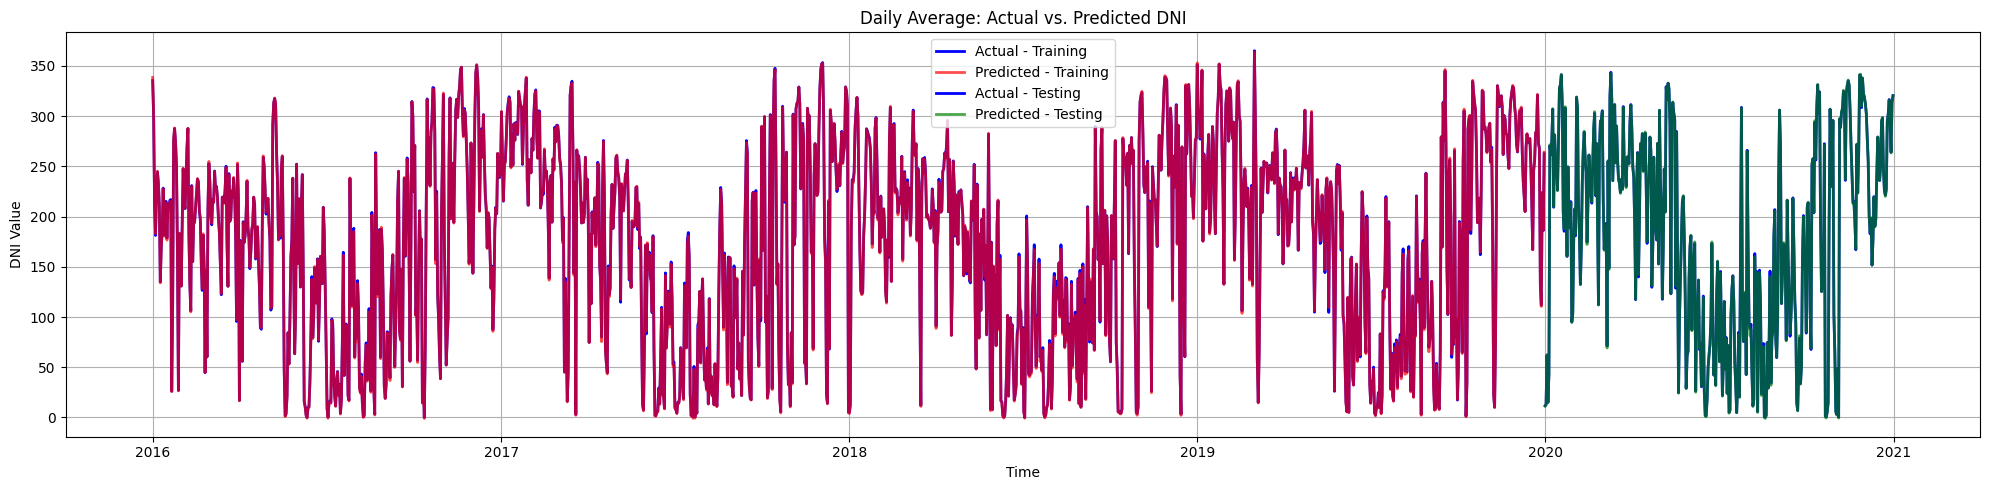

In [35]:
# Reshape data to 1D
y_train_1D = y_train_original.squeeze()
train_predictions_1D = train_predictions_original.squeeze()
y_test_1D = y_test_original.squeeze()
test_predictions_1D = test_predictions_original.squeeze()

# Create dataframes for training and testing sets with datetime as index
train_df = pd.DataFrame(
    {
        "datetime": train_time,
        "Actual": y_train_1D,
        "Predicted": train_predictions_1D,
    }
)
train_df.set_index("datetime", inplace=True)

test_df = pd.DataFrame(
    {
        "datetime": test_time,
        "Actual": y_test_1D,
        "Predicted": test_predictions_1D,
    }
)
test_df.set_index("datetime", inplace=True)

# Resample data to daily frequency and calculate mean
train_daily = train_df.resample("D").mean()
test_daily = test_df.resample("D").mean()

# Plotting
plt.figure(figsize=(20, 5))

# Plotting daily average actual and predicted values for the training set
plt.plot(
    train_daily.index, train_daily["Actual"], label="Actual - Training", color="blue"
)
plt.plot(
    train_daily.index,
    train_daily["Predicted"],
    label="Predicted - Training",
    color="red",
    alpha=0.7,
)

# Plotting daily average actual and predicted values for the testing set
plt.plot(test_daily.index, test_daily["Actual"], label="Actual - Testing", color="blue")
plt.plot(
    test_daily.index,
    test_daily["Predicted"],
    label="Predicted - Testing",
    color="green",
    alpha=0.7,
)

plt.title("Daily Average: Actual vs. Predicted DNI")
plt.xlabel("Time")
plt.ylabel("DNI Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()